<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = None

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import linear_model
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house_raw = pd.read_csv('./housing.csv')
# house_raw.info()

In [4]:
house_samp = house_raw.sample(n=(290))

In [5]:
# A:
# check the main shape
print(house_raw.shape)

(1460, 81)


In [6]:
(house_raw.describe())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


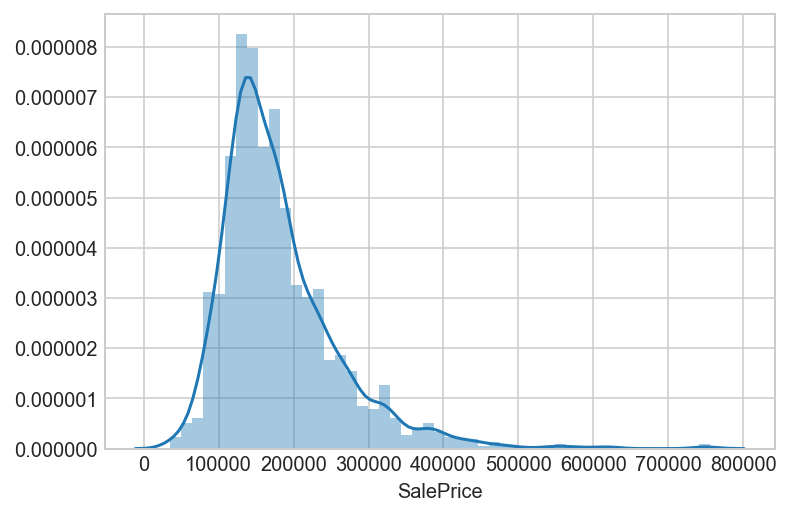

In [7]:
sns.distplot(house_raw.SalePrice)

## Checking for Non-Residential place

In [8]:
checkNonRes = ((house_raw[(house_raw['MSZoning'] == 'A') | (
    house_raw['MSZoning'] == 'C') | (house_raw['MSZoning'] == 'I')]).count())
checkNonRes.sum()

0

## Checking NAs

In [9]:
(house_raw.isna().sum()).sum()

6965

## Select vars for Fixed and Non Fixed - ensure those highlighted with NaN can be parked under Non Fixed

In [10]:
house_raw.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [11]:
len(house_raw.columns.values)

81

In [12]:
house_raw['YrAge'] = house_raw.YrSold + 1 - house_raw.YearBuilt

## Log the SalePrice to make it normally distributed

In [13]:
house_raw['SalePrice'] = np.log(house_raw['SalePrice'])
#  house_raw.SalePrice = house_raw.SalePrice.astype('int64')

In [14]:
house_raw[house_raw.YrAge == 1].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YrAge
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,1031.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1410,1410,GasA,Ex,Y,SBrkr,1426,1519,0,2945,0,0,3,1,3,1,Gd,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3,641,TA,TA,Y,192,0,37,0,0,0,NaN,NaN,NaN,0,10,2006,New,Partial,12.991753,1
87,88,160,FV,40.0,3951,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,612,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2009.0,RFn,2,528,TA,TA,Y,0,234,0,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,12.010666,1
112,113,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,220.0,Gd,TA,PConc,Ex,TA,Av,GLQ,984,Unf,0,280,1264,GasA,Ex,Y,SBrkr,1282,1414,0,2696,1,0,2,1,4,1,Ex,10,Typ,1,Gd,BuiltIn,2007.0,Fin,3,792,TA,TA,Y,120,184,0,0,168,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.858320,1
167,168,60,RL,86.0,10562,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,300.0,Gd,TA,PConc,Ex,TA,No,GLQ,1288,Unf,0,294,1582,GasA,Ex,Y,SBrkr,1610,551,0,2161,1,0,1,1,3,1,Ex,8,Typ,1,Gd,Attchd,2007.0,Fin,3,789,TA,TA,Y,178,120,0,0,0,0,NaN,NaN,NaN,0,11,2007,New,Partial,12.693499,1
196,197,20,RL,79.0,9416,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2007,Hip,CompShg,CemntBd,CmentBd,Stone,205.0,Ex,TA,PConc,Ex,TA,No,GLQ,1126,Unf,0,600,1726,GasA,Ex,Y,SBrkr,1726,0,0,1726,1,0,2,0,3,1,Ex,8,Typ,1,Gd,Attchd,2007.0,Fin,3,786,TA,TA,Y,171,138,0,0,266,0,NaN,NaN,NaN,0,9,2007,New,Partial,12.650348,1


In [15]:
#  current notes:
#  target = 'SalePrice'
#  checking the dates for training 'YrSold'
#  features to include as fixed
#  'MSZoning','LotArea','LotShape','LandContour','LotConfig','LandSlope','Neighbourhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','Foundation'
# ,'BsmtExposure','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','GarageType','GarageYrBlt'
# ,'GarageCars','GarageArea','MoSold','YrSold','SaleType','SaleCondition','YrAge'

#  features which are not fixed:
#  'Id','MSSubClass','Street','Alley','Utilities','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual'
# ,'BsmtCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','Fireplaces','FireplaceQu','GarageFinish'
# ,'GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal'

## Make FIXED DF and Add Sales Price

In [16]:
df = house_raw.copy()
df_fixed = df[['Id', 'MSZoning', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
               'YearRemodAdd', 'Foundation', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
               'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold', 'SaleType', 'SalePrice', 'YrAge']]
(df_fixed.head())

,Id,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,Foundation,BsmtExposure,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageCars,GarageArea,MoSold,YrSold,SaleType,SalePrice,YrAge
0,1,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2003,2003,PConc,No,856,856,854,0,1710,1,0,2,1,3,1,8,Attchd,2003.0,2,548,2,2008,WD,12.247694,6
1,2,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,1976,1976,CBlock,Gd,1262,1262,0,0,1262,0,1,2,0,3,1,6,Attchd,1976.0,2,460,5,2007,WD,12.109011,32
2,3,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2001,2002,PConc,Mn,920,920,866,0,1786,1,0,2,1,3,1,6,Attchd,2001.0,2,608,9,2008,WD,12.317167,8
3,4,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,1915,1970,BrkTil,No,756,961,756,0,1717,1,0,1,0,3,1,7,Detchd,1998.0,3,642,2,2006,WD,11.849398,92
4,5,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,2000,2000,PConc,Av,1145,1145,1053,0,2198,1,0,2,1,4,1,9,Attchd,2000.0,3,836,12,2008,WD,12.429216,9


In [17]:
len(df_fixed.columns.values)

37

In [18]:
(df_fixed.isna().sum()).sum()

200

In [19]:
print('columns total:', (36+47-2))

columns total: 81


In [20]:
(df_fixed.isnull().sum()).sum()

200

## Make NON FIXED DF and Add Sales Price

In [21]:
df_NonFixed = df[['Id', 'MSSubClass', 'LotFrontage', 'Street', 'Alley', 'Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
                  'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'SaleCondition']]
df_NonFixed.head()

,Id,MSSubClass,LotFrontage,Street,Alley,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleCondition
0,1,60,65.0,Pave,NaN,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,Gd,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,Gd,Typ,0,NaN,RFn,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,Normal
1,2,20,80.0,Pave,NaN,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Gd,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,TA,Typ,1,TA,RFn,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,Normal
2,3,60,68.0,Pave,NaN,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,Gd,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,Gd,Typ,1,TA,RFn,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,Normal
3,4,70,60.0,Pave,NaN,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,TA,Gd,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,Gd,Typ,1,Gd,Unf,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,Abnorml
4,5,60,84.0,Pave,NaN,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,Gd,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,Gd,Typ,1,TA,RFn,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,Normal


In [22]:
len(df_NonFixed.columns.values)

46

In [23]:
# may not need 'LotFrontage','Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond', \
# 'PoolQC','Fence','MiscFeature'

## See the Fixed items that are int64

In [24]:
df_fixed2 = df_fixed.select_dtypes(include=['int64'])
df_fixed2[['SalePrice']] = df_fixed[['SalePrice']]

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [25]:
df_fixed2.head()

,Id,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,YrAge,SalePrice
0,1,8450,2003,2003,856,856,854,0,1710,1,0,2,1,3,1,8,2,548,2,2008,6,12.247694
1,2,9600,1976,1976,1262,1262,0,0,1262,0,1,2,0,3,1,6,2,460,5,2007,32,12.109011
2,3,11250,2001,2002,920,920,866,0,1786,1,0,2,1,3,1,6,2,608,9,2008,8,12.317167
3,4,9550,1915,1970,756,961,756,0,1717,1,0,1,0,3,1,7,3,642,2,2006,92,11.849398
4,5,14260,2000,2000,1145,1145,1053,0,2198,1,0,2,1,4,1,9,3,836,12,2008,9,12.429216


In [26]:
df_fixed2.shape

(1460, 22)

In [27]:
(df_fixed2.isnull().sum()).sum()

0

## See the Fixed items that are not int64

In [28]:
df_fixed.select_dtypes(exclude=['int64']).head(10)

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Foundation,BsmtExposure,GarageType,GarageYrBlt,SaleType,SalePrice
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,No,Attchd,2003.0,WD,12.247694
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,CBlock,Gd,Attchd,1976.0,WD,12.109011
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,Mn,Attchd,2001.0,WD,12.317167
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,BrkTil,No,Detchd,1998.0,WD,11.849398
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,PConc,Av,Attchd,2000.0,WD,12.429216
5,RL,IR1,Lvl,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Wood,No,Attchd,1993.0,WD,11.870600
6,RL,Reg,Lvl,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,PConc,Av,Attchd,2004.0,WD,12.634603
7,RL,IR1,Lvl,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,CBlock,Mn,Attchd,1973.0,WD,12.206073
8,RM,Reg,Lvl,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,BrkTil,No,Detchd,1931.0,WD,11.774520
9,RL,Reg,Lvl,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,BrkTil,No,Attchd,1939.0,WD,11.678440


In [29]:
df_fixed_o = df_fixed.select_dtypes(exclude=['int64'])
df_fixed_o.shape

(1460, 16)

In [30]:
df_fixed_o = df_fixed_o.drop(columns=['GarageYrBlt'], axis=1)

In [31]:
df_fixed_o.shape

(1460, 15)

In [32]:
(df_fixed_o.isnull().sum()).sum()

119

In [33]:
#  highlighted for Nan
df_fixed_o[['BsmtExposure', 'GarageType']].isnull().sum()

BsmtExposure    38
GarageType      81
dtype: int64

## Set up dummy coding for object items

In [34]:
#  clean up NaN in the 'BsmtExposure','GarageType'

In [35]:
BsmtExposure_new = df_fixed_o.BsmtExposure.map(
    lambda x: 'ZZZ' if pd.isnull(x) else x)
GarageType_new = df_fixed_o.GarageType.map(
    lambda x: 'ZZZ' if pd.isnull(x) else x)
df_fixed_o['BsmtExposure_new'] = BsmtExposure_new
#  df_fixed_o.head()

In [36]:
df_fixed_o['GarageType_new'] = GarageType_new
#  df_fixed_o.head()

In [37]:
df_fixed_o = df_fixed_o.drop(
    columns=['BsmtExposure', 'GarageType', 'SalePrice'])

In [38]:
df_fixed_o.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Foundation,SaleType,BsmtExposure_new,GarageType_new
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,WD,No,Attchd
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,CBlock,WD,Gd,Attchd
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,WD,Mn,Attchd
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,BrkTil,WD,No,Detchd
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,PConc,WD,Av,Attchd


In [39]:
"""BsmtExposure_new = pd.get_dummies(BsmtExposure_new, prefix='ColumnName')
BsmtExposure_new_dummy.drop('ColumnName_ZZZ', axis=1, inplace=True)"""

"BsmtExposure_new = pd.get_dummies(BsmtExposure_new, prefix='ColumnName')\nBsmtExposure_new_dummy.drop('ColumnName_ZZZ', axis=1, inplace=True)"

In [40]:
df_dummy = []
for colnum, colnme in enumerate(df_fixed_o.columns):
    df_curr = pd.get_dummies(df_fixed_o.iloc[:, colnum], prefix=colnme)
    df_dummy.append(df_curr)

df_dummy = pd.concat(df_dummy, axis=1)

In [41]:
df_dummy.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,BsmtExposure_new_Av,BsmtExposure_new_Gd,BsmtExposure_new_Mn,BsmtExposure_new_No,BsmtExposure_new_ZZZ,GarageType_new_2Types,GarageType_new_Attchd,GarageType_new_Basment,GarageType_new_BuiltIn,GarageType_new_CarPort,GarageType_new_Detchd,GarageType_new_ZZZ
0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [42]:
df_dummy.shape

(1460, 103)

## Append df_fixed int and dummy together

In [43]:
print(df_fixed2.shape, df_dummy.shape)

(1460, 22) (1460, 103)


In [44]:
df_fixed2 = pd.concat([df_fixed2, df_dummy], axis=1)
df_fixed2.shape

(1460, 125)

In [45]:
(df_fixed2.isnull().sum()).sum()

0

## See the Non Fixed items that are not int64


In [46]:
df_NonFixed.select_dtypes(exclude=['int64']).head()

,LotFrontage,Street,Alley,Utilities,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
0,65.0,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
1,80.0,Pave,NaN,AllPub,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Gd,TA,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
2,68.0,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
3,60.0,Pave,NaN,AllPub,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,TA,Gd,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,NaN,Abnorml
4,84.0,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal


## Heatmap for Fixed and Non Fixed to SalesPrice

In [47]:
"""# check corr for fixed
plt.figure(figsize=(20, 20))
# Compute the correlation matrix
corr = df_fixed2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10,s=100,center='dark', as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,square=True, linewidths=1, cbar_kws={"shrink": .5})

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap='plasma', vmax=.5, center=0,
                 square=True, linewidths=1, cbar_kws={"shrink": .5})

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=9)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=9)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()"""

'# check corr for fixed\nplt.figure(figsize=(20, 20))\n# Compute the correlation matrix\ncorr = df_fixed2.corr()\n\n# Generate a mask for the upper triangle\nmask = np.zeros_like(corr, dtype=np.bool)\nmask[np.triu_indices_from(mask)] = True\n\n# Set up the matplotlib figure\nf, ax = plt.subplots(figsize=(20, 20))\n\n# Generate a custom diverging colormap\n#cmap = sns.diverging_palette(240, 10,s=100,center=\'dark\', as_cmap=False)\n\n# Draw the heatmap with the mask and correct aspect ratio\n#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,square=True, linewidths=1, cbar_kws={"shrink": .5})\n\n# Draw the heatmap with the mask and correct aspect ratio\nax = sns.heatmap(corr, mask=mask, cmap=\'plasma\', vmax=.5, center=0,\n                 square=True, linewidths=1, cbar_kws={"shrink": .5})\n\n# Resize the labels.\nax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=9)\nax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=9)\n\n# If you put plt.show() at the bottom, it prev

In [48]:
df_fixed2.SalePrice.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

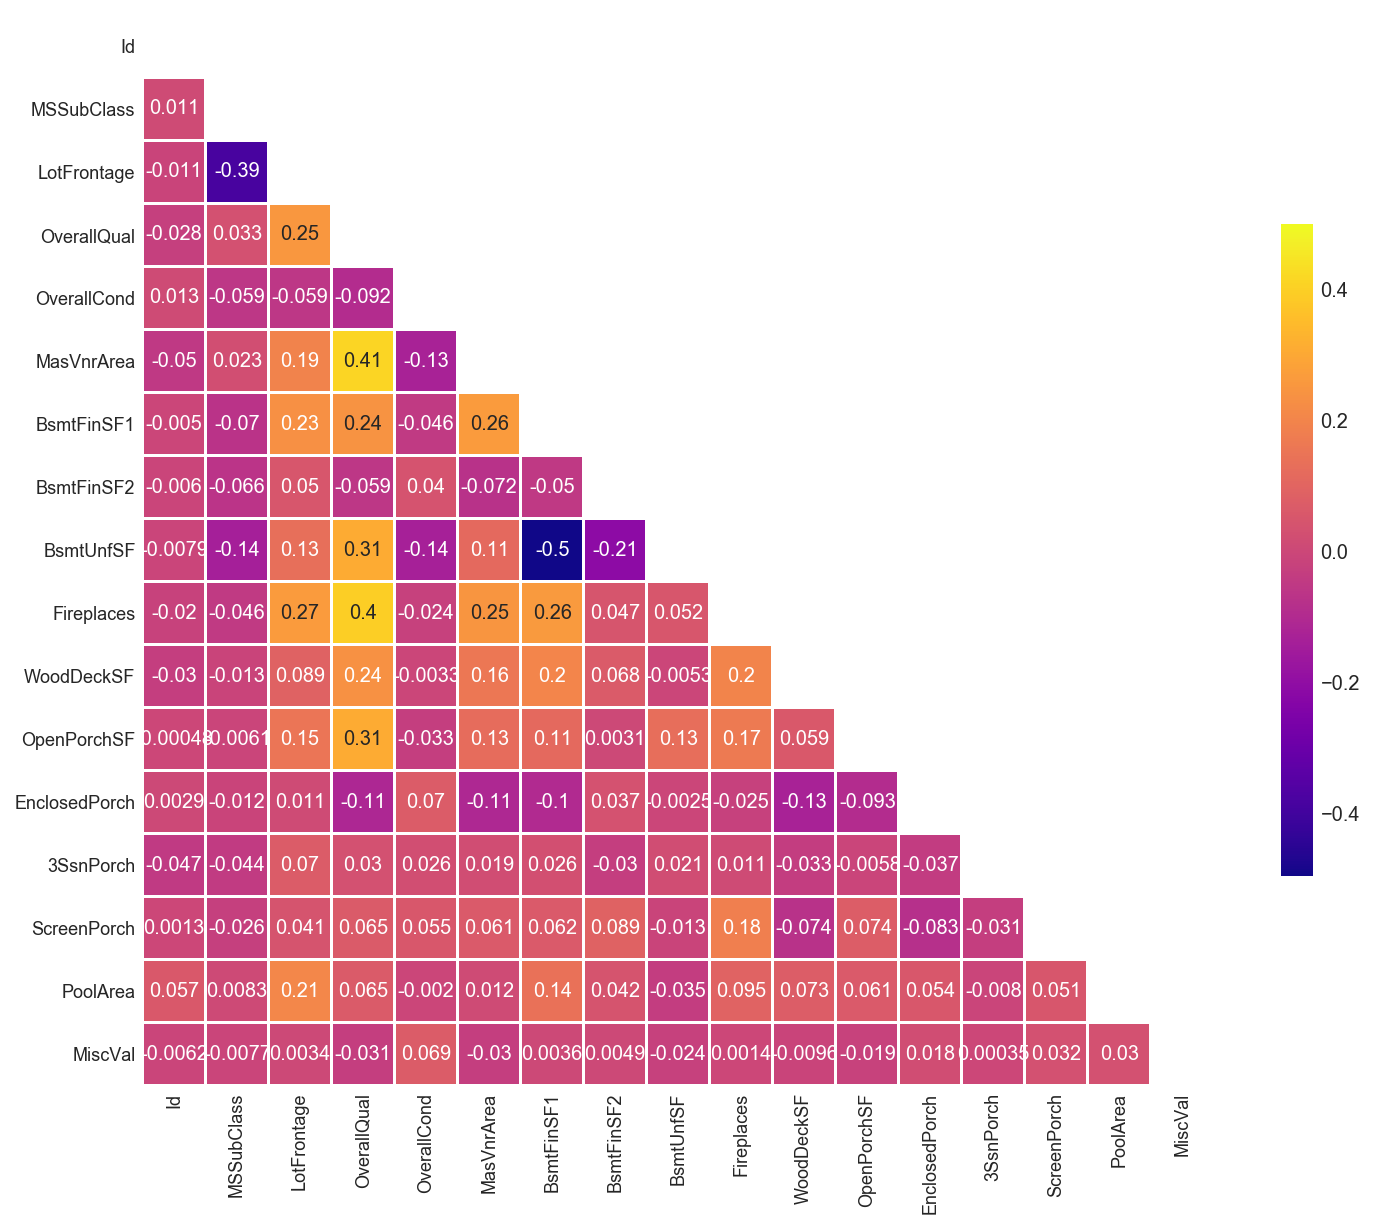

In [49]:
# check corr for fixed
plt.figure(figsize=(20, 20))
# Compute the correlation matrix
corr = df_NonFixed.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(240, 10,s=100,center='dark', as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,square=True, linewidths=1, cbar_kws={"shrink": .5})

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap='plasma', vmax=.5, center=0,
                 square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=9)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=9)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

## Checking paired correlation

In [50]:
fix_corr = df_fixed2.corr()
attrs = fix_corr.iloc[:-1, :-1]  # all except target

threshold = 0.7  # change this however
imp_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]
             ).unstack().dropna().to_dict()

unique_imp_corrs = pd.DataFrame(list(set([(tuple(sorted(
    key)), imp_corrs[key]) for key in imp_corrs])), columns=['Attribute Pair', 'Correlation'])

# sorted by absolute value, however leaves the original correlation val intact
unique_imp_corrs = unique_imp_corrs.loc[abs(
    unique_imp_corrs['Correlation']).argsort()[::-1]]

unique_imp_corrs

,Attribute Pair,Correlation
15,"(YearBuilt, YrAge)",-0.999036
3,"(LotShape_IR1, LotShape_Reg)",-0.925959
13,"(LandSlope_Gtl, LandSlope_Mod)",-0.908607
6,"(GarageArea, GarageCars)",0.882475
1,"(MSZoning_FV, Neighborhood_Somerst)",0.862807
10,"(GrLivArea, TotRmsAbvGrd)",0.825489
4,"(1stFlrSF, TotalBsmtSF)",0.819530
7,"(2ndFlrSF, HouseStyle_2Story)",0.809150
2,"(MSZoning_RL, MSZoning_RM)",-0.808585
14,"(BsmtExposure_new_ZZZ, Foundation_Slab)",0.790836


In [51]:
nonfix_corr = df_NonFixed.corr()
nf_attrs = nonfix_corr.iloc[:-1, :-1]  # all except target

threshold = 0.20
nf_imp_corrs = (nf_attrs[abs(nf_attrs) > threshold]
                [nf_attrs != 1.0]).unstack().dropna().to_dict()

unique_nf_imp_corrs = pd.DataFrame(list(set([(tuple(sorted(
    key)), nf_imp_corrs[key]) for key in nf_imp_corrs])), columns=['Attribute Pair', 'Correlation'])

# sorted by absolute value
unique_nf_imp_corrs = unique_nf_imp_corrs.loc[abs(
    unique_nf_imp_corrs['Correlation']).argsort()[::-1]]

unique_nf_imp_corrs

,Attribute Pair,Correlation
7,"(BsmtFinSF1, BsmtUnfSF)",-0.495251
4,"(MasVnrArea, OverallQual)",0.411876
6,"(Fireplaces, OverallQual)",0.396765
15,"(LotFrontage, MSSubClass)",-0.386347
14,"(OpenPorchSF, OverallQual)",0.308819
17,"(BsmtUnfSF, OverallQual)",0.308159
8,"(Fireplaces, LotFrontage)",0.266639
13,"(BsmtFinSF1, MasVnrArea)",0.264736
16,"(BsmtFinSF1, Fireplaces)",0.260011
3,"(LotFrontage, OverallQual)",0.251646


In [52]:
df_fixed2['YrSold'].head()

0    2008
1    2007
2    2008
3    2006
4    2008
Name: YrSold, dtype: int64

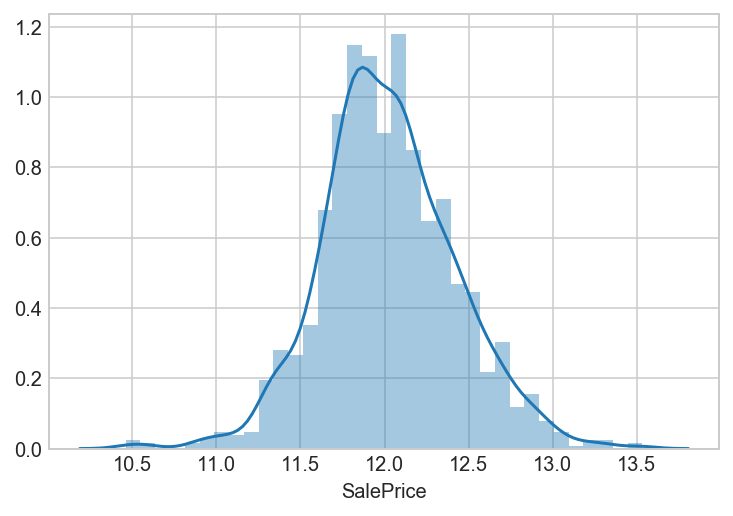

In [53]:
sns.distplot(df_fixed2['SalePrice'])

## Set training data to less than year sold 2010

In [54]:
df_fixed2.shape  # total shape

(1460, 125)

In [55]:
(df_fixed2.isna().sum()).sum()

0

In [56]:
df_f_train = df_fixed2[df_fixed2['YrSold'] < 2010]
df_f_train = df_f_train.drop(columns=['SalePrice'], axis=1)

df_f_train_y = df_fixed2[df_fixed2['YrSold'] < 2010][['SalePrice']]

print(df_f_train.shape, df_f_train_y.shape)

(1285, 124) (1285, 1)


In [57]:
df_f_test = df_fixed2[df_fixed2['YrSold'] >= 2010]
df_f_test = df_f_test.drop(columns=['SalePrice'], axis=1)
df_f_test_y = df_fixed2[df_fixed2['YrSold'] >= 2010][['SalePrice']]

print(df_f_test.shape, df_f_test_y.shape)

(175, 124) (175, 1)


## Train Test Split

In [58]:
X = df_f_train
y = df_f_train_y
#  y= target

#  X_train, X_test, y_train, y_test = train_test_split(df_f_train, y, test_size=0.2)
#  X_train.shape

## Linear Regression - Baseline - 88%


In [59]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)  # this stays for training in memory

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
regprediction = reg.predict(X)
(regprediction)

array([[ 12.2600626 ],
       [ 12.1222577 ],
       [ 12.29941365],
       ..., 
       [ 12.23989967],
       [ 12.11214563],
       [ 11.80889019]])

In [61]:
# linear reg train score
r2_score(y, regprediction)

0.87651161386112419

### Trial = Use coef on df_f_test_y for 2010

In [62]:
regprediction_actual = reg.predict(df_f_test)
r2_score(df_f_test_y, regprediction_actual)

0.87981218621559831

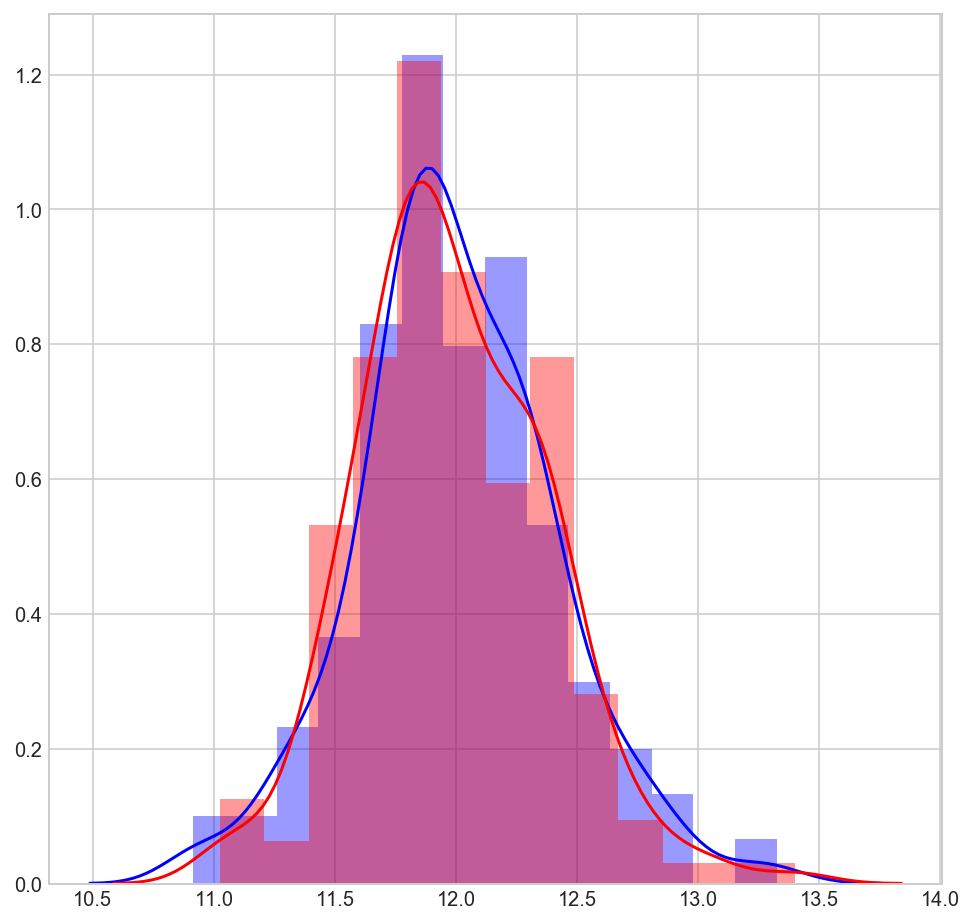

In [63]:
plt.figure(figsize=(8, 8))
sns.distplot(df_f_test_y, color='blue')
sns.distplot(regprediction_actual, color='red')

In [64]:
# test scatter plot
"""plt.figure(figsize=(8, 8))
plt.scatter(regprediction_actual, df_f_test_y)"""

'plt.figure(figsize=(8, 8))\nplt.scatter(regprediction_actual, df_f_test_y)'

In [65]:
len(regprediction_actual)

175

In [66]:
# coefs
linreg_coef = reg.coef_.flatten()
linreg_coef = list(linreg_coef)
print((reg.coef_), (reg.intercept_))

[[ -1.67912445e-05   2.08690187e-06  -1.59937656e-04   2.43432475e-03
    4.13411421e-05   6.99579804e-05   9.71563458e-05   3.24553362e-05
    1.99569619e-04   6.75563267e-02   4.46728729e-02   4.18884828e-02
    4.77011476e-02  -3.54601038e-03  -1.31589027e-01   1.18890210e-02
    6.71451521e-02   1.91570089e-05   2.05127685e-03  -1.57120611e-03
   -1.41126844e-03  -4.25225400e-01   1.09106593e-01   1.11694329e-01
    1.13755119e-01   9.06693583e-02   3.11677467e-02   8.11934631e-02
   -1.43346397e-01   3.09851872e-02  -4.89194088e-02   2.73777054e-02
    1.21797351e-02   9.36196836e-03   1.64055132e-02   5.93856681e-02
   -2.91216724e-02  -6.20449006e-02   1.53753917e-02   5.77225199e-02
    6.67019623e-02  -1.24424482e-01  -2.43935509e-03  -4.77638977e-03
   -5.21905804e-02  -1.65337211e-02  -1.13049405e-02  -2.57832895e-02
    1.44737744e-01  -1.23596318e-01  -5.26854696e-02  -8.08179591e-02
   -1.68100637e-01  -8.22351400e-02  -3.88822796e-02   2.94940932e-02
   -3.77216091e-02  

## Scaling Items

In [67]:
X_colname = list(X.columns.values)
len(X_colname)

124

In [68]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)
#  Xs = (X - np.min(X)) / (np.max(X) - np.min(X))
#  Xs.head()  # samson say okay

In [69]:
df_Xs = pd.DataFrame(Xs, columns=X_colname)
df_Xs.head()
Xs = df_Xs.copy()
Xs.head()

,Id,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,YrAge,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,BsmtExposure_new_Av,BsmtExposure_new_Gd,BsmtExposure_new_Mn,BsmtExposure_new_No,BsmtExposure_new_ZZZ,GarageType_new_2Types,GarageType_new_Attchd,GarageType_new_Basment,GarageType_new_BuiltIn,GarageType_new_CarPort,GarageType_new_Detchd,GarageType_new_ZZZ
0,-1.752369,-0.203120,1.042546,0.879097,-0.457697,-0.791817,1.149267,-0.125132,0.358771,1.132983,-0.252799,0.780146,1.221960,0.164788,-0.206517,0.911798,0.296035,0.332669,-1.691826,0.428387,-1.025415,-0.074009,-0.215446,-0.112287,0.521802,-0.422965,-0.714135,-0.167332,-0.088561,0.770904,-0.215446,-0.194845,-0.162351,0.345453,-0.460721,-0.259376,-0.181544,-0.05588,0.613028,0.238209,-0.217416,-0.092921,-0.112287,-0.039482,-0.108679,-0.213461,-0.137958,2.894747,-0.196986,-0.272791,-0.24542,-0.157229,-0.104952,-0.1905,-0.419122,-0.074009,-0.232686,-0.164858,-0.238209,-0.288918,-0.13198,-0.217416,-0.192683,-0.254211,-0.125739,-0.162351,-0.092921,-0.183818,-0.243633,0.395747,-0.0625,-0.115788,-0.07915,-0.140859,-0.027907,-0.05588,-0.039482,-0.0625,0.104952,-0.027907,-0.039482,-0.027907,-0.027907,-0.039482,0.439465,-0.143706,-0.1905,-0.174566,-0.288918,-0.346863,-0.104952,-0.982259,-0.07915,-0.092921,1.503802,-0.157229,-0.217416,-0.344040,-0.859556,1.109461,-0.128895,-0.05588,-0.039482,-0.174566,-0.05588,-0.027907,-0.083984,-0.05588,-0.0625,-0.313513,-0.048375,0.402299,-0.417838,-0.325349,-0.290496,0.730351,-0.162351,-0.068492,0.82980,-0.104952,-0.254211,-0.07915,-0.609424,-0.240027
1,-1.749975,-0.092266,0.154431,-0.428693,0.460728,0.256468,-0.803227,-0.125132,-0.488645,-0.800461,3.757659,0.780146,-0.763146,0.164788,-0.206517,-0.320880,0.296035,-0.072809,-0.586966,-0.460914,-0.171265,-0.074009,-0.215446,-0.112287,0.521802,-0.422965,-0.714135,-0.167332,-0.088561,0.770904,-0.215446,-0.194845,-0.162351,0.345453,-0.460721,-0.259376,5.508309,-0.05588,-1.631248,0.238209,-0.217416,-0.092921,-0.112287,-0.039482,-0.108679,-0.213461,-0.137958,-0.345453,-0.196986,-0.272791,-0.24542,-0.157229,-0.104952,-0.1905,-0.419122,-0.074009,-0.232686,-0.164858,-0.238209,-0.288918,-0.13198,-0.217416,-0.192683,-0.254211,-0.125739,-0.162351,10.761886,-0.183818,4.104537,-2.526867,-0.0625,-0.115788,-0.07915,-0.140859,-0.027907,-0.05588,-0.039482,-0.0625,0.104952,-0.027907,-0.039482,-0.027907,

## KBest

In [70]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [71]:
cols = list(df_fixed2.columns)
cols.remove('SalePrice')

# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression, k=10)
#  skb_chi2 = SelectKBest(chi2)

In [72]:
# Train the selector on the data.
skb_f.fit(Xs, y.values.ravel())
#skb_chi2.fit_transform(Xs, y.values.ravel())
listofIndices = skb_f.transform(Xs).argsort()[::-1][10]
listofIndices = list(listofIndices)
print((skb_f.scores_).shape)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], index=[
                     'feature', 'f_reg'])
kbest = kbest.T
kbest = kbest.iloc[listofIndices]
kbest.sort_values('f_reg', ascending=False)

(124,)


,feature,f_reg
8,GrLivArea,1232.14
4,TotalBsmtSF,728.88
5,1stFlrSF,690.79
2,YearBuilt,650.962
3,YearRemodAdd,615.508
6,2ndFlrSF,153.224
1,LotArea,87.2073
9,BsmtFullBath,77.4348
7,LowQualFinSF,1.92847
0,Id,0.823503


In [73]:
#

##  Testing Accuracy with Lasso Regression and Lasso Feature Select


In [74]:
print(Xs.shape, y.shape)

(1285, 124) (1285, 1)


In [75]:
# Using LassoCV to come up with best coefficients


def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, Xs, y,
                                    scoring="neg_mean_squared_error", cv=5))
    return(rmse)


# running the lasso model
model_lasso = LassoCV(n_alphas=100, selection='random',
                      max_iter=15000).fit(Xs, y)
res = rmse_cv(model_lasso)
print("Mean:", res.mean())
print("Min: ", res.min())

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_mod

Mean: 0.168247987365
Min:  0.134194391194


In [76]:
model_lasso.coef_

array([-0.00336528,  0.01519908,  0.01234012,  0.05156234,  0.02505556,
        0.00565229,  0.        , -0.        ,  0.14509798,  0.03056463,
        0.00653025,  0.01696202,  0.01145237,  0.        , -0.02447349,
        0.01208349,  0.05762391,  0.00330336,  0.00292798, -0.        ,
       -0.03462592, -0.03733409,  0.        , -0.        ,  0.        ,
       -0.01838336,  0.        ,  0.00441719, -0.01244565, -0.        ,
       -0.00790704,  0.0009054 ,  0.        , -0.        , -0.        ,
        0.00915793, -0.0023988 , -0.        , -0.        , -0.        ,
        0.        , -0.00650083, -0.        ,  0.        , -0.        ,
        0.00206007,  0.        ,  0.        ,  0.03185911, -0.01990437,
       -0.00154897, -0.        , -0.01047923, -0.0064149 , -0.        ,
        0.        ,  0.        ,  0.01565773,  0.04329066, -0.00619974,
       -0.        , -0.0042123 ,  0.        ,  0.01878946,  0.02457231,
        0.00442437,  0.00958193, -0.00512457, -0.0111316 ,  0.00

In [77]:
coef = pd.Series(model_lasso.coef_, index=df_f_test.columns)
coef_df = pd.DataFrame(model_lasso.coef_, columns=['lasso_coef'])
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

Lasso picked 69 variables and eliminated the other 55 variables


In [78]:
a = coef > 0
a

Id                        False
LotArea                    True
YearBuilt                  True
YearRemodAdd               True
TotalBsmtSF                True
1stFlrSF                   True
2ndFlrSF                  False
LowQualFinSF              False
GrLivArea                  True
BsmtFullBath               True
BsmtHalfBath               True
FullBath                   True
HalfBath                   True
BedroomAbvGr              False
KitchenAbvGr              False
TotRmsAbvGrd               True
GarageCars                 True
GarageArea                 True
MoSold                     True
YrSold                    False
YrAge                     False
MSZoning_C (all)          False
MSZoning_FV               False
MSZoning_RH               False
MSZoning_RL               False
MSZoning_RM               False
LotShape_IR1              False
LotShape_IR2               True
LotShape_IR3              False
LotShape_Reg              False
                          ...  
HouseSty

In [79]:
coef_df['col_names'] = list(df_f_test.columns)
coef_df['boolean'] = list(a)
coef_df[coef_df['boolean'] == True]

,lasso_coef,col_names,boolean
1,0.015199,LotArea,True
2,0.012340,YearBuilt,True
3,0.051562,YearRemodAdd,True
4,0.025056,TotalBsmtSF,True
5,0.005652,1stFlrSF,True
8,0.145098,GrLivArea,True
9,0.030565,BsmtFullBath,True
10,0.006530,BsmtHalfBath,True
11,0.016962,FullBath,True
12,0.011452,HalfBath,True


In [80]:
# Creating a DataFrame of the IDs and the predicted price
Xs = df_f_test
ss = StandardScaler()

Xs_test = ss.fit_transform(Xs)
#  Xs = (X - np.min(X)) / (np.max(X) - np.min(X))
#  Xs.head()  # samson say okay

df_fixed_predictions = model_lasso.predict(Xs_test)

df_fixed_pred = pd.DataFrame()
df_fixed_pred['df_pred_Id'] = df_f_test['Id']
df_fixed_pred['df_fixedPrediction'] = df_fixed_predictions
df_fixed_pred['SalePrice'] = df_f_test_y
df_fixed_pred['residual'] = np.round(
    df_fixed_pred['SalePrice'] - df_fixed_pred['df_fixedPrediction'], 2)

In [81]:
df_fixed_pred.head()

,df_pred_Id,df_fixedPrediction,SalePrice,residual
16,17,11.922911,11.911702,-0.01
24,25,11.912200,11.944708,0.03
26,27,11.868936,11.811547,-0.06
27,28,12.662225,12.631340,-0.03
33,34,12.101172,12.016726,-0.08


In [82]:
list_dffixed = list(df_fixed_pred['df_pred_Id'].head(10))
list_dffixed_ = []
for item in list_dffixed:
    item = item - 1
    list_dffixed_.append(item)
list_dffixed_

[16, 24, 26, 27, 33, 38, 45, 52, 63, 66]

In [83]:
df_fixed2_filt = df_fixed2.iloc[list_dffixed_]
df_fixed2_filt

,Id,LotArea,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,YrAge,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,BsmtExposure_new_Av,BsmtExposure_new_Gd,BsmtExposure_new_Mn,BsmtExposure_new_No,BsmtExposure_new_ZZZ,GarageType_new_2Types,GarageType_new_Attchd,GarageType_new_Basment,GarageType_new_BuiltIn,GarageType_new_CarPort,GarageType_new_Detchd,GarageType_new_ZZZ
16,17,11241,1970,1970,1004,1004,0,0,1004,1,0,1,0,2,1,5,2,480,3,2010,41,11.911702,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
24,25,8246,1968,2001,1060,1060,0,0,1060,1,0,1,0,3,1,6,1,270,5,2010,43,11.944708,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
26,27,7200,1951,2000,900,900,0,0,900,0,1,1,0,3,1,5,2,576,5,2010,60,11.811547,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
27,28,11478,2007,2008,1704,1704,0,0,1704,1,0,2,0,3,1,7,3,772,5,2010,4,12.631340,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
33,34,10552,1959,1959,1398,1700,0,0,1700,0,1,1,1,4,1,6,2,447,4,2010,52,12.016726,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
38,39,7922,1953,2007,1057,1057,0,0,1057,1,0,1,0,3,1,5,1,246,1,2010,58,11.599103,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
45,46,7658,2005,2005,1752,1752,0,0,1752,1,0,2,0,2,1,6,2,576,2,2010,6,12.675764,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

## Making new df from top5 features and comparing LinM and LassoCV

In [84]:
df5 = df_fixed2[['GrLivArea', 'GarageCars', 'TotalBsmtSF',
                 'YearBuilt', 'YearRemodAdd', 'YrSold', 'YrAge', 'SalePrice']]
df5.head()

,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,YearRemodAdd,YrSold,YrAge,SalePrice
0,1710,2,856,2003,2003,2008,6,12.247694
1,1262,2,1262,1976,1976,2007,32,12.109011
2,1786,2,920,2001,2002,2008,8,12.317167
3,1717,3,756,1915,1970,2006,92,11.849398
4,2198,3,1145,2000,2000,2008,9,12.429216


In [85]:
df5_n2010 = df5[df5['YrSold'] < 2010]
df5_2010 = df5[df5['YrSold'] >= 2010]
train = df5_n2010.drop(labels=['SalePrice'], axis=1)
train_y = df5_n2010[['SalePrice']]
test = df5_2010.drop(labels=['SalePrice'], axis=1)
test_y = df5_2010[['SalePrice']]

print(df5_n2010.shape, df5_2010.shape, train.shape,
      train_y.shape, test.shape, test_y.shape)

(1285, 8) (175, 8) (1285, 7) (1285, 1) (175, 7) (175, 1)


In [86]:
train_col_nme = list(train.columns.values)

In [87]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
train_s = ss.fit_transform(train)
test_s = ss.fit_transform(test)
train_df = pd.DataFrame(train_s, columns=train_col_nme)
test_df = pd.DataFrame(test_s, columns=train_col_nme)
train_df.head()

,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,YearRemodAdd,YrSold,YrAge
0,0.358771,0.296035,-0.457697,1.042546,0.879097,0.428387,-1.025415
1,-0.488645,0.296035,0.460728,0.154431,-0.428693,-0.460914,-0.171265
2,0.502529,0.296035,-0.312920,0.976760,0.830660,0.428387,-0.959711
3,0.372012,1.626121,-0.683910,-1.852051,-0.719313,-1.350215,1.799852
4,1.281848,1.626121,0.196059,0.943867,0.733787,0.428387,-0.926859


## LinearModel with top5

In [88]:
lmclf = linear_model.LinearRegression()

lmclf.fit(train_df, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
lmclf_pred = lmclf.predict(train_df)
lmclf_pred.shape

(1285, 1)

In [90]:
lmclf_pred

array([[ 12.22558037],
       [ 11.98939462],
       [ 12.25125856],
       ..., 
       [ 12.13195352],
       [ 12.20655885],
       [ 11.79606833]])

In [91]:
lmclf_coef = lmclf.coef_
lmclf_coef

array([[ 0.1682318 ,  0.08759227,  0.0713229 ,  0.0409699 ,  0.07090899,
        -0.00576203, -0.04113143]])

In [92]:
lmclf_train_score = r2_score(train_y, lmclf_pred)
lmclf_train_score

0.77498464960136471

## Use coef to test on 2010 data

In [93]:
lmclf_act = lmclf.predict(test_df)
lmclf_act.shape

(175, 1)

In [94]:
lmclf_test_score = r2_score(test_y, lmclf_act)
lmclf_test_score

0.82358631645107483

In [95]:
linear_scores = cross_val_score(lmclf, train, train_y.values.ravel(), cv=10)

print('Sel_fea linear CV Score:{} std:{}'.format(
    round(np.mean(linear_scores), 4), round(np.std(linear_scores), 4)))

Sel_fea linear CV Score:0.7532 std:0.1397


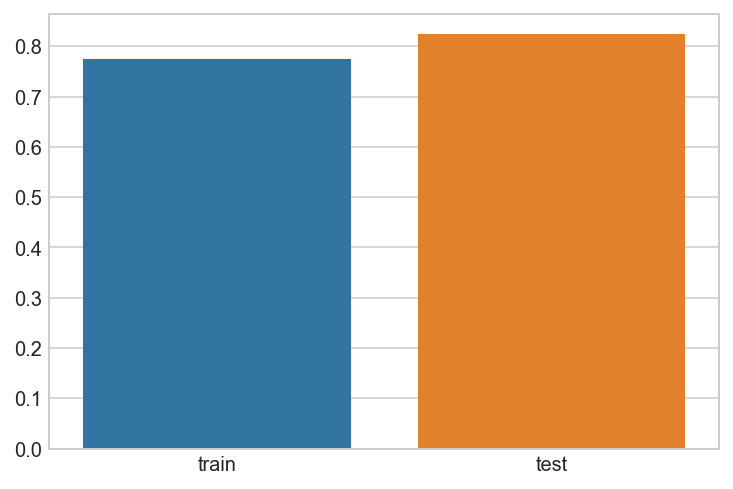

In [96]:
sns.barplot(x=['train', 'test'], y=[lmclf_train_score, lmclf_test_score])

## LassoCV with top5

In [97]:
optimal_lasso = linear_model.LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(train_df, train_y.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [98]:
optimal_lasso_alpha = optimal_lasso.alpha_
optimal_lasso_alpha

0.0052462989301911411

In [99]:
clflcv = linear_model.Lasso(alpha=optimal_lasso_alpha)
clflcv.fit(train_df, train_y.values.ravel())

Lasso(alpha=0.0052462989301911411, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [100]:
clflcv_pred = clflcv.predict(train_df)
clflcv_pred

array([ 12.22321058,  11.98827989,  12.24844076, ...,  12.13367297,
        12.20078715,  11.80222038])

In [101]:
clflcv_coef = clflcv.coef_
clflcv_coef

array([ 0.16567931,  0.08655241,  0.06916023,  0.        ,  0.06819804,
       -0.        , -0.08061961])

In [102]:
clflcv_train_score = r2_score(train_y, clflcv_pred)

In [103]:
lasso_scores = cross_val_score(clflcv, train_df, train_y.values.ravel(), cv=10)

print('Sel_fea Lasso CV Score:{} std:{}'.format(
    round(np.mean(lasso_scores), 4), round(np.std(lasso_scores), 4)))

Sel_fea Lasso CV Score:0.7539 std:0.1326


## use coef to test on 2010 data

In [104]:
clflcv_act = clflcv.predict(test_df)
clflcv_test_score = r2_score(test_y, clflcv_act)

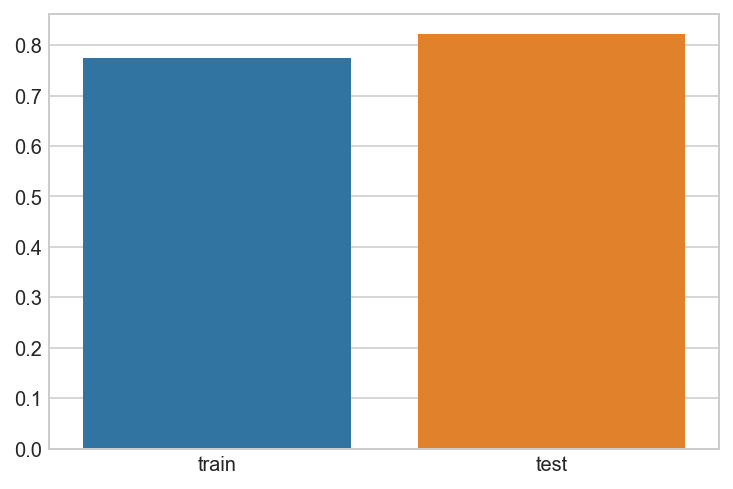

In [105]:
sns.barplot(x=['train', 'test'], y=[clflcv_train_score, clflcv_test_score])

In [106]:
finscore_df = pd.DataFrame([lmclf_train_score, lmclf_test_score,
                            clflcv_train_score, clflcv_test_score], columns=['Score'])
finscore_df['type_score'] = ['lmclf_train_score',
                             'lmclf_test_score', 'clflcv_train_score', 'clflcv_test_score']
finscore_df

,Score,type_score
0,0.774985,lmclf_train_score
1,0.823586,lmclf_test_score
2,0.774538,clflcv_train_score
3,0.821120,clflcv_test_score


In [107]:
#  mean dollar value 20180702

## Exploratory Graphs

### Check GrLivArea as it is one of the more reasonable high correlation variables
### Garage built and year built have high correlation due to probably being built at the same time most likely

In [108]:
plt.figure(figsize=(10, 10))

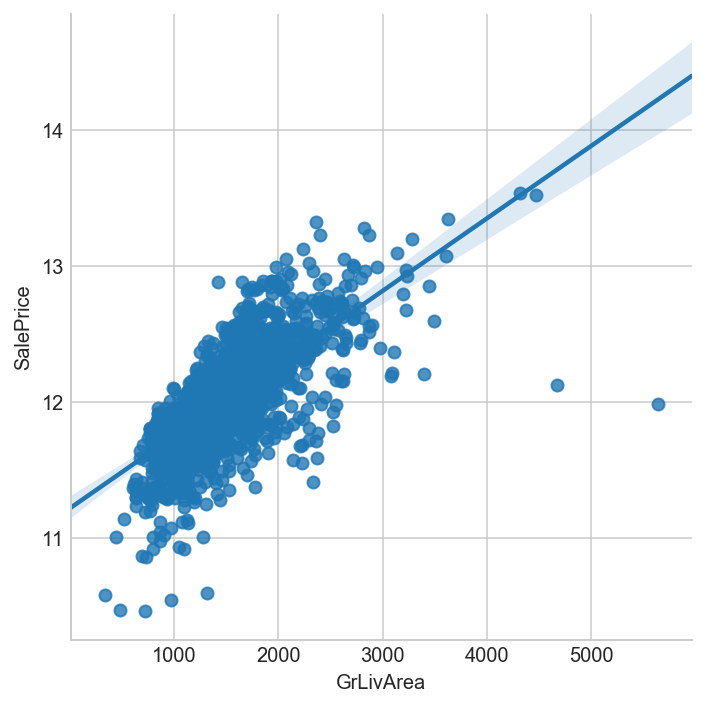

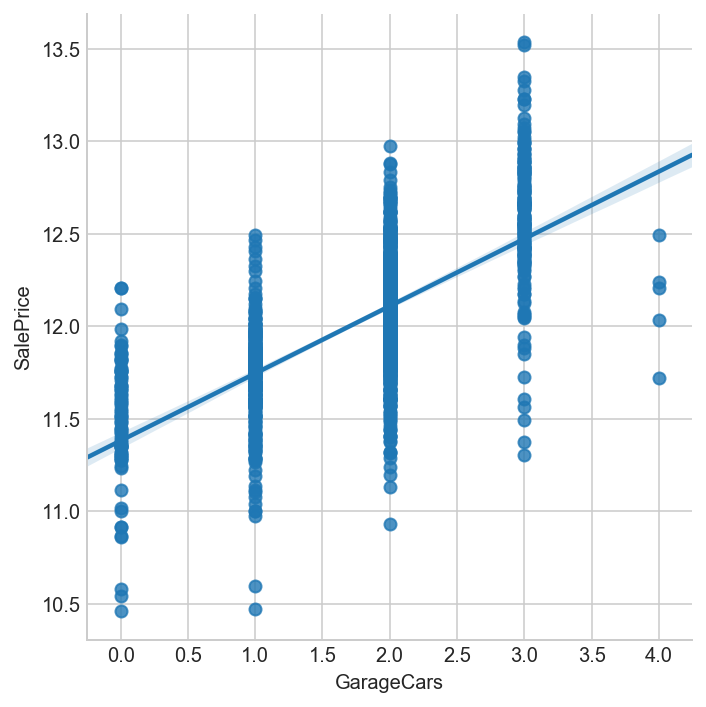

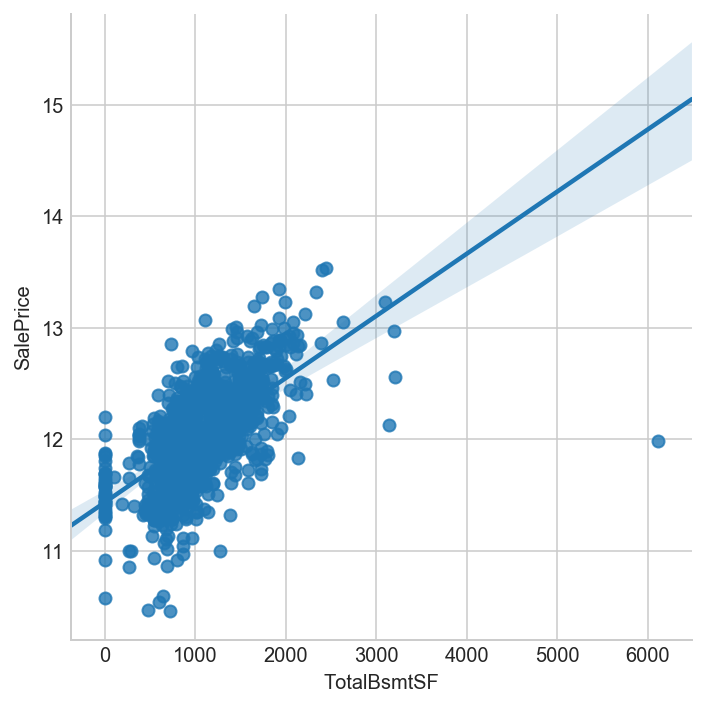

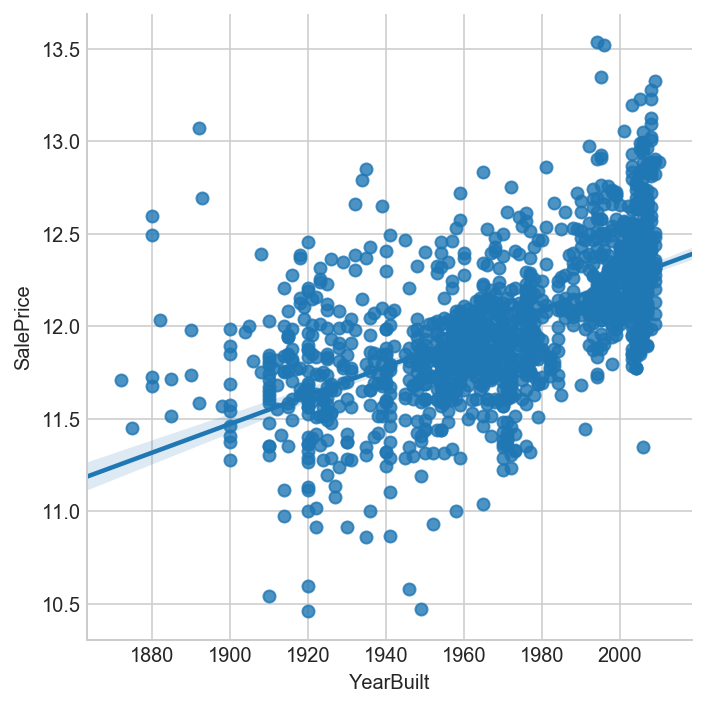

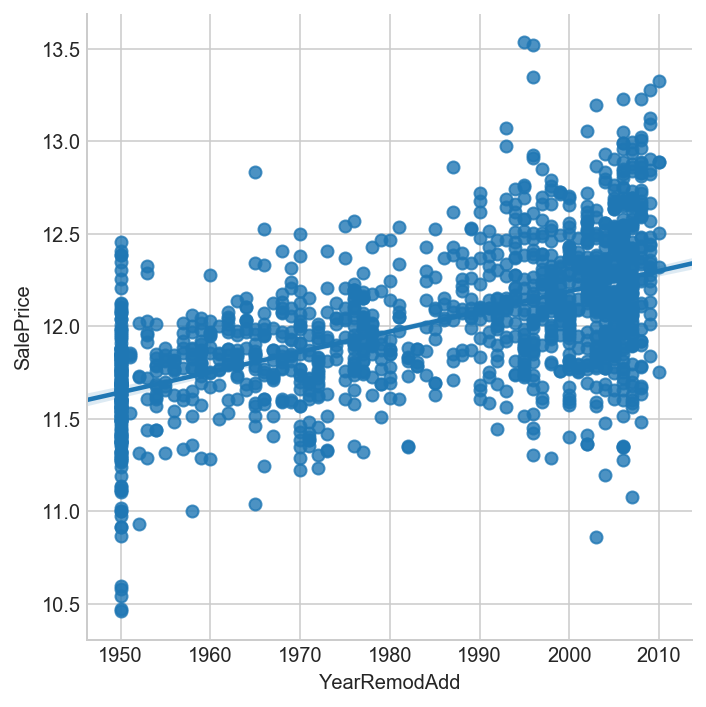

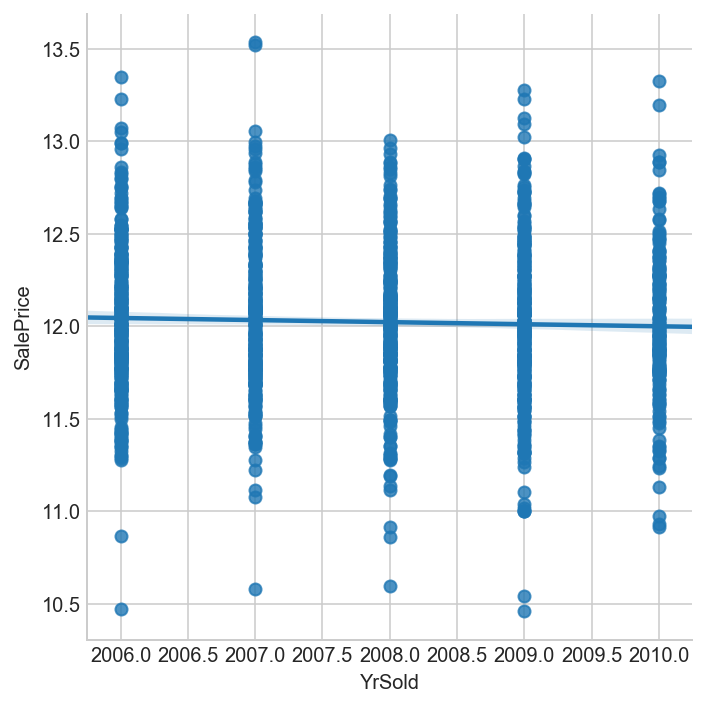

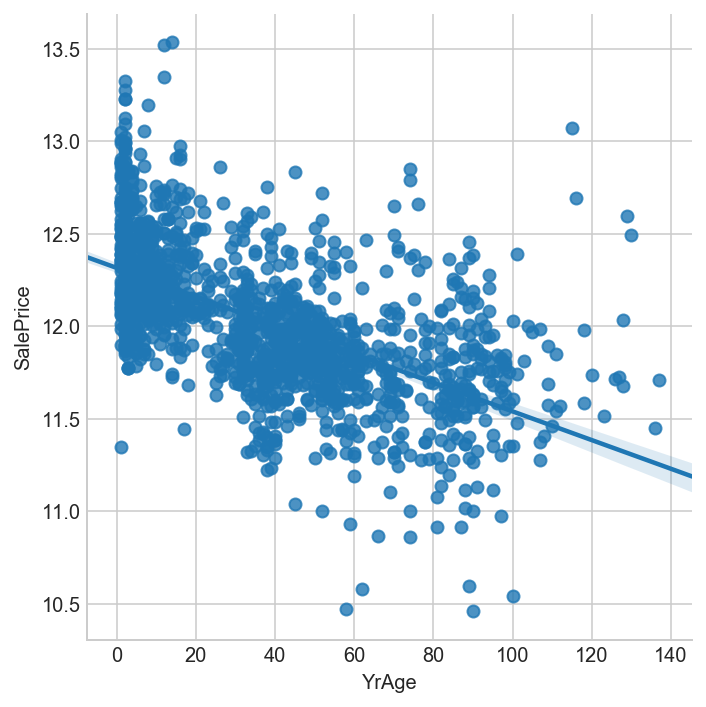

In [109]:
['GrLivArea', 'GarageCars', 'TotalBsmtSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'YrAge']
sns.lmplot(x='GrLivArea', y='SalePrice', data=df_fixed2)
sns.lmplot(x='GarageCars', y='SalePrice', data=df_fixed2)
sns.lmplot(x='TotalBsmtSF', y='SalePrice', data=df_fixed2)
sns.lmplot(x='YearBuilt', y='SalePrice', data=df_fixed2)
sns.lmplot(x='YearRemodAdd', y='SalePrice', data=df_fixed2)
sns.lmplot(x='YrSold', y='SalePrice', data=df_fixed2)
sns.lmplot(x='YrAge', y='SalePrice', data=df_fixed2)

## Characterising the model

The linear model residual score is slightly higher than the lasso r2 score probably due to the amount of features used in the "final" dataframe.
The linear regression model seems to explain a proper relationship between dependent variable (SalePrice) and multi-independent variables (X)
using a best fit straight line ("as it is").

As for the Lasso Regression model - the amount of features that have been coefficients reduced to Zero have already been removed when I downsized the sample features to just the top 5. Therefore by running the lassoCV again, it may be over-optimising the model to select few features.



## Performance of the model

Good.

## Best Features - Feature Selection

'GrLivArea','GarageCars','TotalBsmtSF','YearBuilt','YearRemodAdd','YrSold','SalePrice'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Residuals explaining the difference in the house values

In [110]:
# A:

## Calc Train Residual


In [111]:
df5_n2010.iloc[:, 7].head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [112]:
#df5_n2010['residual']=df5_n2010.iloc[:,8].values - lmclf_pred
df5_n2010['predict'] = lmclf_pred.ravel()
df5_n2010['residual'] = df5_n2010['predict'] - df5_n2010.SalePrice
df5_n2010.head()

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,YearRemodAdd,YrSold,YrAge,SalePrice,predict,residual
0,1710,2,856,2003,2003,2008,6,12.247694,12.225580,-0.022114
1,1262,2,1262,1976,1976,2007,32,12.109011,11.989395,-0.119616
2,1786,2,920,2001,2002,2008,8,12.317167,12.251259,-0.065908
3,1717,3,756,1915,1970,2006,92,11.849398,11.990287,0.140889
4,2198,3,1145,2000,2000,2008,9,12.429216,12.525604,0.096388


## Calc Test Residual

In [113]:
df5_2010['predict'] = lmclf_act
df5_2010['residual'] = df5_2010['predict'] - df5_2010.SalePrice
df5_2010.tail()

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,YearRemodAdd,YrSold,YrAge,SalePrice,predict,residual
1438,1236,2,912,1957,1996,2010,54,11.916389,11.956947,0.040559
1446,1188,1,1188,1962,1962,2010,49,11.969717,11.761784,-0.207933
1456,2073,2,1542,1978,1988,2010,33,12.254863,12.381259,0.126397
1457,2340,1,1152,1941,2006,2010,70,12.493130,12.235674,-0.257456
1458,1078,1,1078,1950,1996,2010,61,11.864462,11.788291,-0.076172


## Make a list for residual

In [114]:
df5_ = pd.concat([df5_n2010, df5_2010])

df5_.head()

,GrLivArea,GarageCars,TotalBsmtSF,YearBuilt,YearRemodAdd,YrSold,YrAge,SalePrice,predict,residual
0,1710,2,856,2003,2003,2008,6,12.247694,12.225580,-0.022114
1,1262,2,1262,1976,1976,2007,32,12.109011,11.989395,-0.119616
2,1786,2,920,2001,2002,2008,8,12.317167,12.251259,-0.065908
3,1717,3,756,1915,1970,2006,92,11.849398,11.990287,0.140889
4,2198,3,1145,2000,2000,2008,9,12.429216,12.525604,0.096388


## making a df_nonfixed with residual

In [115]:
df_nfr = pd.concat(
    [df_NonFixed, df5_[['YrSold', 'SalePrice', 'predict', 'residual']]], axis=1)

In [116]:
a = df_nfr.MasVnrArea.mean(skipna=True)
b = df_nfr.SalePrice.mean(skipna=True)
c = df_nfr.LotFrontage.mean(skipna=True)
d = df_nfr.predict.mean(skipna=True)

In [117]:
b

12.024050901109373

In [118]:
df_nfr.MasVnrArea = df_nfr.MasVnrArea.fillna(value=a)
df_nfr.SalePrice = df_nfr.SalePrice.fillna(value=b)
df_nfr.LotFrontage = df_nfr.LotFrontage.fillna(value=c)
df_nfr.predict = df_nfr.predict.fillna(value=d)

In [119]:
df_nfr.residual = df_nfr.residual.astype('int64')

df_nfr.MasVnrArea = df_nfr.MasVnrArea.astype('int64', errors='ignore')
df_nfr.SalePrice = df_nfr.SalePrice.astype('int64', errors='ignore')
df_nfr.LotFrontage = df_nfr.LotFrontage.astype('int64', errors='ignore')

df_nfr.predict = df_nfr.predict.astype('int64', errors='ignore')
df_nfr.head()

,Id,MSSubClass,LotFrontage,Street,Alley,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleCondition,YrSold,SalePrice,predict,residual
0,1,60,65,Pave,NaN,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,Gd,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,Gd,Typ,0,NaN,RFn,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,Normal,2008,12,12,0
1,2,20,80,Pave,NaN,AllPub,6,8,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,Gd,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,TA,Typ,1,TA,RFn,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,Normal,2007,12,11,0
2,3,60,68,Pave,NaN,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,Gd,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,Gd,Typ,1,TA,RFn,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,Normal,2008,12,12,0
3,4,70,60,Pave,NaN,AllPub,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,TA,Gd,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,Gd,Typ,1,Gd,Unf,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,Abnorml,2006,11,11,0
4,5,60,84,Pave,NaN,AllPub,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,Gd,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,Gd,Typ,1,TA,RFn,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,Normal,2008,12,12,0


In [120]:
df_nfr.LotFrontage.head()

0    65
1    80
2    68
3    60
4    84
Name: LotFrontage, dtype: int64

## see for int type

In [121]:
df_nfr_int = df_nfr.select_dtypes(include=['int64'])
df_nfr_int.head()

,Id,MSSubClass,LotFrontage,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,predict,residual
0,1,60,65,7,5,196,706,0,150,0,0,61,0,0,0,0,0,2008,12,12,0
1,2,20,80,6,8,0,978,0,284,1,298,0,0,0,0,0,0,2007,12,11,0
2,3,60,68,7,5,162,486,0,434,1,0,42,0,0,0,0,0,2008,12,12,0
3,4,70,60,7,5,0,216,0,540,1,0,35,272,0,0,0,0,2006,11,11,0
4,5,60,84,8,5,350,655,0,490,1,192,84,0,0,0,0,0,2008,12,12,0


## see for o type

In [122]:
df_nfr_o = df_nfr.select_dtypes(exclude=['int64'])
df_nfr_o.head()

,Street,Alley,Utilities,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
0,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
1,Pave,NaN,AllPub,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
2,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
3,Pave,NaN,AllPub,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,Gd,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,NaN,Abnorml
4,Pave,NaN,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,NaN,Normal


## get dummies for o type

In [123]:
colnme_n = df_nfr_o.columns.values
colnme_n

array(['Street', 'Alley', 'Utilities', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleCondition'], dtype=object)

In [124]:
"""BsmtExposure_new = df_fixed_o.BsmtExposure.map(lambda x: 'ZZZ' if pd.isnull(x) else x)
GarageType_new = df_fixed_o.GarageType.map(lambda x: 'ZZZ' if pd.isnull(x) else x)"""

"BsmtExposure_new = df_fixed_o.BsmtExposure.map(lambda x: 'ZZZ' if pd.isnull(x) else x)\nGarageType_new = df_fixed_o.GarageType.map(lambda x: 'ZZZ' if pd.isnull(x) else x)"

In [125]:
df_nfr_o.fillna(value="ZZZ", inplace=True)
(df_nfr_o.head())

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,Street,Alley,Utilities,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
0,Pave,ZZZ,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,ZZZ,RFn,TA,TA,Y,ZZZ,ZZZ,ZZZ,Normal
1,Pave,ZZZ,AllPub,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,Gd,TA,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,ZZZ,ZZZ,ZZZ,Normal
2,Pave,ZZZ,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,ZZZ,ZZZ,ZZZ,Normal
3,Pave,ZZZ,AllPub,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,TA,Gd,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,ZZZ,ZZZ,ZZZ,Abnorml
4,Pave,ZZZ,AllPub,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,Gd,TA,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,ZZZ,ZZZ,ZZZ,Normal


In [126]:
df_dummyn = []
for colnumn, colnmen in enumerate(df_nfr_o.columns):
    df_currn = pd.get_dummies(df_nfr_o.iloc[:, colnumn], prefix=colnmen)
    df_dummyn.append(df_currn)

df_dummyn = pd.concat(df_dummyn, axis=1)
df_dummyn.head()

,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_ZZZ,Utilities_AllPub,Utilities_NoSeWa,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_ZZZ,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_ZZZ,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_ZZZ,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_ZZZ,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_ZZZ,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_ZZZ,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_ZZZ,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_ZZZ,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_ZZZ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_ZZZ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_ZZZ,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_ZZZ,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_ZZZ,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0
4,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [127]:
df_nfr = pd.concat([df_nfr_int, df_dummyn], axis=1)
df_nfr.head()

,Id,MSSubClass,LotFrontage,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,predict,residual,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_ZZZ,Utilities_AllPub,Utilities_NoSeWa,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_ZZZ,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_ZZZ,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_ZZZ,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_ZZZ,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_ZZZ,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_ZZZ,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_ZZZ,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_ZZZ,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_ZZZ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_ZZZ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_ZZZ,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_ZZZ,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_ZZZ,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65,7,5,196,706,0,150,0,0,61,0,0,0,0,0,2008,12,12,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,2,20,80,6,8,0,978,0,284,1,298,0,0,0,0,0,0,2007,12,11,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,3,60,68,7,5,162,486,0,434,1,0,42,0,0,0,0,0,2008,12,12,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,4,70,60,7,5,0,21

## Scale df_nfr

In [152]:
X_train = df_nfr[df_nfr['YrSold'] < 2010].drop(labels=['SalePrice'], axis=1)
y_train = df_nfr[df_nfr['YrSold'] < 2010]['SalePrice']

X_test = df_nfr[df_nfr['YrSold'] >= 2010].drop(labels=['SalePrice'], axis=1)
y_test = df_nfr[df_nfr['YrSold'] >= 2010]['SalePrice']

In [153]:
y_train.shape

(1285,)

In [154]:
print(X_train.shape, '\n', y_train.shape,
      '\n', X_test.shape, '\n', y_test.shape)

(1285, 185) 
 (1285,) 
 (175, 185) 
 (175,)


In [155]:
ss = StandardScaler()
Xs_colname = X_train.columns.values

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [156]:
df_Xs_train = pd.DataFrame(Xs_train, columns=Xs_colname)
df_Xs_train.shape

(1285, 185)

In [157]:
df_Xs_test = pd.DataFrame(Xs_test, columns=Xs_colname)
df_Xs_test.shape

(175, 185)

## create a SelectKbest and linear model

In [158]:
cols = list(df_nfr.columns)
cols.remove('SalePrice')

# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression, k=22)
#  skb_chi2 = SelectKBest(chi2)

# Train the selector on the data.
skb_f.fit(df_Xs_train, y.values.ravel())
#  kb_chi2.fit_transform(Xs, y.values.ravel())

C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brian\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SelectKBest(k=22, score_func=<function f_regression at 0x0000021AFFA06B70>)

In [159]:
listofIndices = skb_f.transform(df_Xs_train).argsort()[::-1][10]
listofIndices

array([13,  5,  3, 15,  4,  8, 12, 17,  1, 19,  2, 10, 14,  7,  0, 21,  9,
        6, 16, 18, 11, 20], dtype=int64)

In [160]:
# the ::1 reverses the argsort
listofIndices = list(listofIndices)
print((skb_f.scores_).shape)

(185,)


In [166]:
# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], index=[
                     'feature', 'f_reg'])
kbest = kbest.T
kbest = kbest.iloc[listofIndices]
kbest_sort20 = kbest.sort_values('f_reg', ascending=False)
kbest_sort20

,feature,f_reg
3,OverallQual,2565.48
18,predict,1419.71
9,Fireplaces,415.686
5,MasVnrArea,285.573
6,BsmtFinSF1,186.449
10,WoodDeckSF,174.779
2,LotFrontage,168.585
11,OpenPorchSF,146.774
8,BsmtUnfSF,67.2184
12,EnclosedPorch,29.7823


In [167]:
list(kbest_sort20['feature'])

['OverallQual',
 'predict',
 'Fireplaces',
 'MasVnrArea',
 'BsmtFinSF1',
 'WoodDeckSF',
 'LotFrontage',
 'OpenPorchSF',
 'BsmtUnfSF',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'MSSubClass',
 '3SsnPorch',
 'OverallCond',
 'YrSold',
 'Id',
 'Street_Pave',
 'Street_Grvl',
 'BsmtFinSF2',
 'MiscVal',
 'residual']

## Linear Model on the train

In [179]:
# remove predict
X_train_s = df_Xs_train[['OverallQual', 'Fireplaces', 'MasVnrArea',
                         'BsmtFinSF1', 'WoodDeckSF',  'LotFrontage',
                         'OpenPorchSF',   'BsmtUnfSF',  'EnclosedPorch',
                         'ScreenPorch', 'PoolArea', 'MSSubClass',
                         '3SsnPorch', 'OverallCond', 'YrSold',
                         'Street_Pave', 'Street_Grvl',
                         'BsmtFinSF2', 'MiscVal']]

In [180]:
X_test_s = df_Xs_test[['OverallQual', 'Fireplaces', 'MasVnrArea',
                         'BsmtFinSF1', 'WoodDeckSF',  'LotFrontage',
                         'OpenPorchSF',   'BsmtUnfSF',  'EnclosedPorch',
                         'ScreenPorch', 'PoolArea', 'MSSubClass',
                         '3SsnPorch', 'OverallCond', 'YrSold',
                         'Street_Pave', 'Street_Grvl',
                         'BsmtFinSF2', 'MiscVal']]

In [181]:
X_train_s.shape

(1285, 19)

In [182]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train_s, y_train)
lm_regpred = reg.predict(X_train_s)
(lm_regpred).shape

(1285,)

In [183]:
r2_score(y_train, lm_regpred)

0.55205209010890699

In [184]:
(reg.coef_).shape

(19,)

In [185]:
reg_coefs = pd.DataFrame({'variable': X_train_s.columns,
                          'coef': reg.coef_,
                          'abs_coef': np.abs(reg.coef_)})

reg_coefs.sort_values('abs_coef', inplace=True, ascending=False)

reg_coefs.head(20)

,abs_coef,coef,variable
0,0.288819,0.288819,OverallQual
1,0.078203,0.078203,Fireplaces
4,0.054682,0.054682,WoodDeckSF
6,0.046011,0.046011,OpenPorchSF
5,0.030966,0.030966,LotFrontage
9,0.030431,0.030431,ScreenPorch
8,0.028432,-0.028432,EnclosedPorch
13,0.025944,-0.025944,OverallCond
7,0.019542,0.019542,BsmtUnfSF
12,0.018581,0.018581,3SsnPorch


In [176]:
reg.intercept_

11.507431534011275

In [177]:
reg_scores = cross_val_score(reg, X_train_s, y_train.values.ravel(), cv=10)

print('X_Train Sel_feature linear CV Score:{} std:{}'.format(
    round(np.mean(reg_scores), 4), round(np.std(reg_scores), 4)))

X_Train Sel_feature linear CV Score:0.551 std:0.0423


In [178]:
reg_scores = cross_val_score(reg, X_test_s, y_test.values.ravel(), cv=10)

print('X_test Sel_feature linear CV Score:{} std:{}'.format(
    round(np.mean(reg_scores), 4), round(np.std(reg_scores), 4)))

X_test Sel_feature linear CV Score:0.4731 std:0.2113


<p><strong>Goals Explained:</strong></p>
<ol>
<li><span style="color: blue;">Evaluate the effect in dollars of the renovate-able features.</span>
<ol>
<li>Without specifically attaching a dollar value to the renovatable feature, as we have done a log-conversion on SalesPrice</li>
<li>We can assume that the coefficients in this case as seen above will indicate the strength of the "jump" with an increase of any renovatable feature.</li>
</ol>
</li>
<li><span style="color: blue;">How would your company use this second model and its coefficients to determine whether they should buy a property or not?</span>
<ol>
<li><span style="color: #000000;">The coefficients that are generated in the second model [for Non fixed features], can be applied to a new set of data points to predict its estimated price in terms of residual amount, where from here on we will assume it is the estimated renovation-price.</span></li>
<li><span style="color: #000000;">Where the estimated or predicted amount in the training set is marked against the actual value of the selling price, we can see if there is a margin to gain by renovating certain features of the house.</span></li>
</ol>
</li>
<li><span style="color: blue;">Explain how the company can use the two models you have built to determine if they can make money,&nbsp;</span><span style="color: blue;">Investigate how much of the variance in price remaining is explained by these features.</span>
<ol>
<li><span style="color: #000000;">Again, after scaling the data set, and log(y) the SalePrice and indrectly the residuals, it is harder to make a direct interpretation of the data. But based on certain features, the strength of how strong a feature affects the final selling price will be indicative.&nbsp;</span></li>
</ol>
</li>
<li><span style="color: blue;">Do you trust your model? Should it be used to evaluate which properties to buy and fix up?</span>
<ol>
<li><span style="color: #000000;">I'm willing to trust my model to a certain degree. Most of the values seem to be highly correlated mostly to the size of certain portions of the house. Therefore, I would still trust that the first model that tracked linear relations of fixed features will affect the amount of the house greater.</span></li>
</ol>
</li>
</ol>
<hr />
<p>&nbsp;</p>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnormal` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [147]:
# A:

In [148]:
# B